In [135]:
import numpy as np
import pandas as pd

This is a template for your final project. 

In [136]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0


### Part 1.

Task formalization and Evaluation criteria

1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

The target variable is the avg_vote column.  It is a continuous variable. We use it as a proxy for film success calculaton. In my opinion, it is the only variable that can be used this way directly.

In [137]:
#Let's separate target from the dataset
target_variable = full_dataset['avg_vote']
full_dataset = full_dataset.drop(['avg_vote'], axis = 1)

1.2 Explain which task are you going to solve (is it a regression, classification or something else)? 

 In my opinion, the task we are going to solve is related to the regression task, as our target variable is a continous variable. Our goal is to predict the average vote for the movie. 

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it. 

In my opinion, we should think about the distribution of the target variable to choose the apporpiate metric. If it is distributed without significant outliers, we will opt for the mean squared error, and we will go for the mean absolute error if we have a bunch of them. We will use r2_score to estimate the quality of the model, as it is a well-known an easy to interpret metric.

In [138]:
target_variable.describe()

count    60198.000000
mean         5.997349
std          1.199483
min          1.000000
25%          5.400000
50%          6.200000
75%          6.800000
max         10.000000
Name: avg_vote, dtype: float64

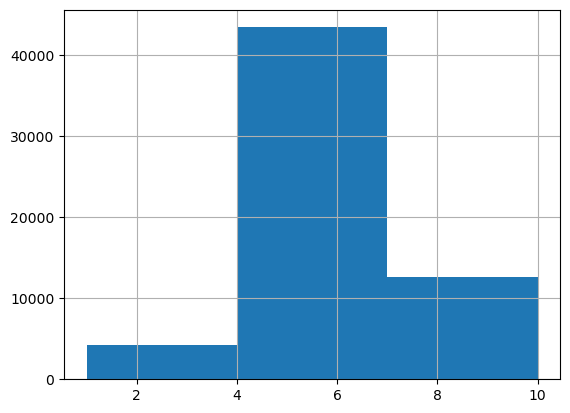

In [139]:
import matplotlib as plt
hist = target_variable.hist(bins=3)

In my opinion, both numeric distribution and histogram show we don't have a lot of outliers both if we speak in terms of absolute values (distribution is from 0 to 10) and in terms of numbers of outliers (standard deviation is around 1). So, we can use mean squared error

In [140]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Part 2.

Explore and preprocess the data

2.1 Split data into train and test

In [141]:
from sklearn.model_selection import train_test_split

In [142]:
y_train, y_test = train_test_split(target_variable, test_size=0.25, random_state=0)
X_train, X_test = train_test_split(full_dataset, test_size=0.25, random_state=0)

2.2 Explore you data: make plots, print tables. Make sure to write your observations.  Do not forget to fill-in missing values, define relevant columns transformatios. 


First and foremost, let's deal with the missing values. 

In [143]:
print(X_train.isna().sum())

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      5
language                   321
director                    20
writer                     613
production_company        2053
actors                      26
description               1489
votes                        0
budget                   32669
usa_gross_income         36231
worlwide_gross_income    30896
metascore                38585
reviews_from_users        3059
reviews_from_critics      6213
dtype: int64


In [144]:
#Let's delete all columns which have >10000 missing values
X_train = X_train.drop(['budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore'], axis = 1)

In [145]:
#Let's then delete all columns which do not have any predictive value. 
X_train = X_train.drop(['imdb_title_id', 'title', 'original_title', 
'date_published', 'director', 'writer', 'production_company', 'actors', 'description'], axis = 1)

In [146]:
X_test = X_test.drop(['budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore'], axis = 1)
X_test = X_test.drop(['imdb_title_id', 'title', 'original_title',
'date_published', 'director', 'writer', 'production_company', 'actors', 'description'], axis = 1)

In [147]:
#Let's divide all the rest columns into lists of numerical and categorical features, as 
#we will treat them in a diffent way. 
num_features = X_train.select_dtypes(include=np.number).columns
cat_features = X_train.select_dtypes(exclude=np.number).columns
print(num_features)
print(cat_features)

Index(['year', 'duration', 'votes', 'reviews_from_users',
       'reviews_from_critics'],
      dtype='object')
Index(['genre', 'country', 'language'], dtype='object')


In [148]:
#Check how many unique values are there between columns with categorical values
print(X_train[cat_features].nunique())

genre       1109
country     2694
language    2579
dtype: int64


In [149]:
#Check if there are highly correlated columns and columns with zero variance among columns with numeric values.
print(X_train[num_features].var())
print(X_train[num_features].corr())

year                    5.436251e+02
duration                5.336457e+02
votes                   2.976019e+09
reviews_from_users      2.222892e+04
reviews_from_critics    3.033598e+03
dtype: float64
                          year  duration     votes  reviews_from_users  \
year                  1.000000  0.186550  0.103095            0.103607   
duration              0.186550  1.000000  0.129742            0.139321   
votes                 0.103095  0.129742  1.000000            0.839921   
reviews_from_users    0.103607  0.139321  0.839921            1.000000   
reviews_from_critics  0.194310  0.140885  0.680925            0.729503   

                      reviews_from_critics  
year                              0.194310  
duration                          0.140885  
votes                             0.680925  
reviews_from_users                0.729503  
reviews_from_critics              1.000000  


On one hand, we see that votes and reviews_from_users are highly correlated. Still, I do not find correlaton extreme enough to delete one of the columns. 

In [150]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [151]:
#We will handle missing values in such manner: median for numeric and mode for categoric values
#We will also use OneHotEncoder for categoric data
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [152]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', cat_imputer),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
], remainder='passthrough')

### Part 3.

Train and compare the models

3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

I am planning to use Ridge, Lasso and Random Forest Regression models in my analysis. 

In [153]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor  

In [154]:
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())])

mse_rigde = cross_val_score(pipe_ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(f"Mean MSE: {-mse_rigde.mean():.3f} +/- {mse_rigde.std():.3f}")

r2_ridge = cross_val_score(pipe_ridge, X_train, y_train, cv=10, scoring='r2')
print(f"Mean R^2: {r2_ridge.mean():.3f} +/- {r2_ridge.std():.3f}")

Mean MSE: 0.837 +/- 0.020
Mean R^2: 0.419 +/- 0.010


In [155]:
pipe_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1))])

mse_lasso = cross_val_score(pipe_lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(f"Mean MSE: {-mse_lasso.mean():.3f} +/- {mse_lasso.std():.3f}")

r2_lasso = cross_val_score(pipe_lasso, X_train, y_train, cv=10, scoring='r2')
print(f"Mean R^2: {r2_lasso.mean():.3f} +/- {r2_lasso.std():.3f}")

Mean MSE: 1.160 +/- 0.017
Mean R^2: 0.195 +/- 0.003


In [156]:
pipe_RFR = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators = 10))])

mse_RFR = cross_val_score(pipe_RFR, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Mean MSE: {-mse_RFR.mean():.3f} +/- {mse_RFR.std():.3f}")

r2_RFR = cross_val_score(pipe_RFR, X_train, y_train, cv=5, scoring='r2')
print(f"Mean R^2: {r2_RFR.mean():.3f} +/- {r2_RFR.std():.3f}")

Mean MSE: 0.769 +/- 0.012
Mean R^2: 0.464 +/- 0.006


3.2 Use cross-validation to compare models and select best set of hyperparameters

In [157]:
from sklearn.model_selection import GridSearchCV

In [158]:
params = {
    'regressor__alpha': [0, 0.1, 1, 10, 100],
    'regressor__solver': ['svd', 'cholesky', 'sparse_cg', 'sag']
}
ridge_ = GridSearchCV(pipe_ridge, params, cv=5, scoring='neg_root_mean_squared_error')
ridge_.fit(X_train, y_train)
best_model_ridge = ridge_.best_estimator_
best_model_ridge

/Users/nikita/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nikita/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nikita/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nikita/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, *

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['year', 'duration', 'votes', 'reviews_from_users',
       'reviews_from_critics'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['genre', 'country', 'language'], dtype='object'))])),
                ('regressor', Ridge(alpha=10, solver='sparse_cg'))])

In [159]:
params = {
    'regressor__alpha': [0.1, 0.5, 1, 10, 100],
    'regressor__max_iter': [100, 500, 1000],
    'regressor__selection': ['cyclic', 'random']
}
lasso_ = GridSearchCV(pipe_lasso, params, cv=5, scoring='neg_root_mean_squared_error')
lasso_.fit(X_train, y_train)
best_model_lasso = lasso_.best_estimator_
best_model_lasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['year', 'duration', 'votes', 'reviews_from_users',
       'reviews_from_critics'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['genre', 'country', 'language'], dtype='object'))])),
                ('regressor', Lasso(alpha=0.1, selection='random'))])

In [160]:
param_grid = {
    'regressor__n_estimators': [10, 15, 20, 25],
}
svr = GridSearchCV(pipe_RFR, param_grid = param_grid, cv=5, scoring='neg_root_mean_squared_error')
svr.fit(X_train, y_train)
best_model_svr = svr.best_estimator_
best_model_svr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['year', 'duration', 'votes', 'reviews_from_users',
       'reviews_from_critics'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['genre', 'country', 'language'], dtype='object'))])),
                ('regressor', RandomForestRegressor(n_estimators=25))])

3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?

In [161]:
best_model_ridge.fit(X_train, y_train)
y_pred = best_model_ridge.predict(X_test)
print(f"MSE for Ridge: {mean_squared_error(y_test, y_pred):.3f}")
print(f"R^2 for Ridge: {r2_score(y_test, y_pred):.3f}")

MSE for Ridge: 0.822
R^2 for Ridge: 0.426


In [162]:
best_model_lasso.fit(X_train, y_train)
y_pred = best_model_lasso.predict(X_test)
print(f"MSE for Lasso: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R^2 for Lasso: {r2_score(y_test, y_pred):.3f}")

MSE for Lasso: 1.1490
R^2 for Lasso: 0.198


In [163]:
best_model_svr.fit(X_train, y_train)
y_pred = best_model_svr.predict(X_test)
print(f"MSE for RandomF: {mean_squared_error(y_test, y_pred):.3f}")
print(f"R^2 for RandomF: {r2_score(y_test, y_pred):.3f}")

MSE for RandomF: 0.723
R^2 for RandomF: 0.495


In my opinion, as we have std of +- 1, having mse of 0.7 is a decent, but not a perfect result. Anyway, Random Forest Regressor works significantly better than simple regressions, and we should continue using it in future. RFR performance is decent both on training and test dataset. What we should definitely work on is features selection and features engineering, as it looks too simplistic for me now. For example, we may have some useful data from season when the film was released. 